![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)
the Non-negative Matrix Factorization decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items and you can simply dot-product them to get an estimated rating.
In addition to NMF, neural networks can also be used to extract the latent user and item features? In fact, neural networks are very good at learning patterns from data and are widely used to extract latent features. When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.

In [4]:
# !pip install tensorflow==2.7.0

In [5]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [6]:
# also set a random state
rs = 123

In [8]:
rating_url = "http://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [9]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a 33901 x 1 one-hot vector and each item can be represented as 126 x 1 one-hot vector.

The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course).

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)
The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes 33901 x 1 one-hot vector as input and outputs a 16 x 1 embedding vector.

The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.

Implementing the recommender neural network using tensorflow
This network architecture could be defined and implemented as a sub-class inheriting the tensorflow.keras.Model super class, let's call it RecommenderNet()

In [10]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [11]:
#Train and evaluate the RecommenderNet()
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [12]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [13]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [14]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [16]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [17]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [18]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [19]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

2023-11-15 19:23:19.608155: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.compile(optimizer = SGD(learning_rate = .003), loss = "MeanSquaredError", metrics=["RootMeanSquaredError"]) 
history = model.fit( x=x_train, y=y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val),verbose = 1)
# model.save()
history.history.keys()

Epoch 1/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0410 - root_mean_squared_error: 0.2022 - val_loss: 0.0945 - val_root_mean_squared_error: 0.3073
Epoch 2/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0398 - root_mean_squared_error: 0.1992 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3054
Epoch 3/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0386 - root_mean_squared_error: 0.1962 - val_loss: 0.0924 - val_root_mean_squared_error: 0.3039
Epoch 4/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0378 - root_mean_squared_error: 0.1941 - val_loss: 0.0916 - val_root_mean_squared_error: 0.3025
Epoch 5/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0368 - root_mean_squared_error: 0.1916 - val_loss: 0.0911 - val_root_mean_squared_error: 0.3017
Epoch 6/10
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0363 - root_mean_squared_error: 0.1903 - val_loss: 0

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

Text(0.5, 1.0, 'RMSE over iterations')

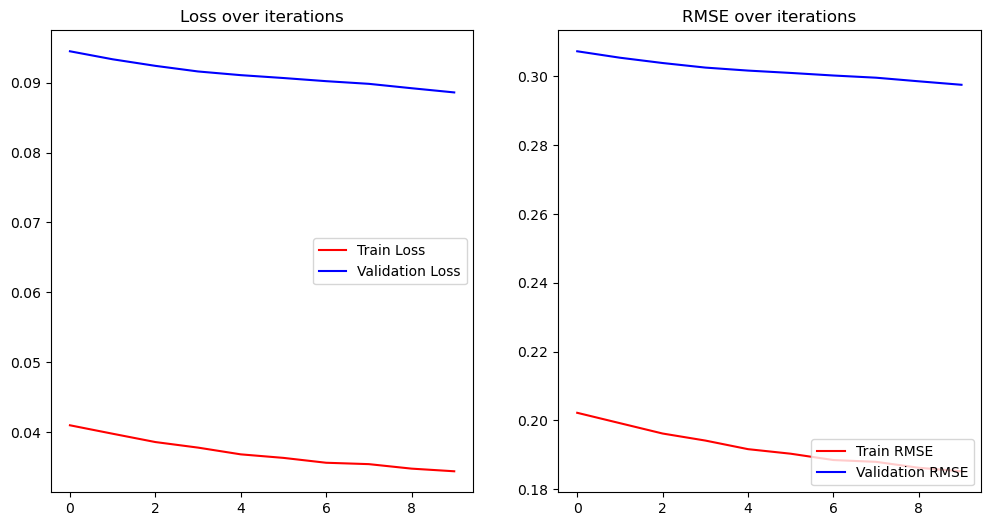

In [22]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6)) # Initiate the figure 
ax = fig.add_subplot(1, 2, 1) # bounding box 1 
ax.plot(range(n), (history.history["loss"]),'r', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)  # bounding box 2
ax.plot(range(n), (history.history["root_mean_squared_error"]),'r', label="Train RMSE")
ax.plot(range(n), (history.history["val_root_mean_squared_error"]),'b', label="Validation RMSE")

ax.legend(loc='lower right')
ax.set_title('RMSE over iterations')

In [23]:
model.evaluate( x_test, y_test)

730/730 [==============================] - 0s 625us/step - loss: 0.1855 - root_mean_squared_error: 0.4306


[0.18552431464195251, 0.43063274025917053]

In [24]:
#Extract the user and item embedding vectors as latent feature vectors
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 542416    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 2016      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


In [25]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [26]:
user_latent_features[0]

array([ 0.02344957, -0.0009096 , -0.01709654,  0.02001848,  0.00999975,
        0.00350054, -0.00097717,  0.00392776,  0.00868221, -0.01385871,
        0.00832384, -0.00476048,  0.0033259 ,  0.0114514 , -0.0037977 ,
       -0.00777461], dtype=float32)

In [27]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [28]:
item_latent_features[0]

array([ 0.17147613,  0.22103836, -0.0290372 , -0.1853262 , -0.01459602,
       -0.01883912,  0.0351123 ,  0.03968453,  0.06268182, -0.34699908,
        0.09056894,  0.04894664,  0.31734863,  0.16939159,  0.19537368,
       -0.05783929], dtype=float32)